<div align="right"><i>Бронников Егор</i></p>

# Лабораторная работа №3

## Импорты

In [1]:
from enum import Enum
from random import randint, choice, choices
from typing import Callable, Any, Self
from collections import defaultdict
from sys import settrace, maxsize
from types import FrameType
from inspect import getsourcelines, getmodule, getmembers, isfunction
from math import pow
from string import printable
from ast import NodeVisitor, FunctionDef, Call, Name, Attribute, parse
from abc import ABC, abstractmethod
from statistics import mean
from re import compile
from concurrent.futures import ThreadPoolExecutor, TimeoutError
from copy import deepcopy
from json import dumps, JSONDecodeError

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from antlr4 import TerminalNode, CommonTokenStream, InputStream
from antlr4.Parser import Parser
from antlr_json.JSONLexer import JSONLexer
from antlr_json.JSONParser import JSONParser

In [2]:
from json import loads as json_loads

from custom_json_parse import parse as custom_parse
from failed_custom_json_parse import parse as failed_parse

## Greybox Grammar Fuzzer

Функции для работы с грамматикой

In [3]:
RE_NONTERMINAL = compile(r"<[^<> ]*>")

In [4]:
def non_terminals(expansion: str | list[str]) -> list[str]:
    if isinstance(expansion, list):
        expansion = expansion[0]

    return RE_NONTERMINAL.findall(expansion)

In [5]:
def is_non_terminal(expansion: str) -> bool:
    return RE_NONTERMINAL.match(expansion) is not None

`Tracer` – класс для отслеживания выполнения программы

In [6]:
class Tracer:
    def __init__(self: Self) -> None:
        self.called_functions = set()
        self.executed_lines = set()

    def reset(self: Self) -> None:
        self.called_functions.clear()
        self.executed_lines.clear()

    def trace_lines(self: Self, frame: FrameType, event: str, arg: Any) -> None:
        if event != "line":
            return
        self.executed_lines.add(frame.f_lineno)

    def trace_calls(self: Self, frame: FrameType, event: str, arg: Any) -> FrameType | None:
        if event != "call":
            return
        func_name = frame.f_code.co_name
        self.called_functions.add(func_name)
        return self.trace_lines
    
    def trace(self: Self, function: Callable[..., Any], *args, **kwargs) -> Any:
        self.reset()
        settrace(self.trace_calls)
        result = function(*args, **kwargs)
        settrace(None)
        return result

__Примеры__

In [7]:
tracer = Tracer()

In [8]:
valid_json = '{"abc": 123}'
tracer.trace(custom_parse, valid_json)

{'abc': 123}

In [9]:
print(tracer.called_functions)

{'_skip_whitespace', 'parse', '_parse_value', '_parse_number', '_parse_object', '_parse_string'}


In [10]:
print(tracer.executed_lines)

{8, 9, 10, 13, 15, 17, 18, 19, 21, 22, 33, 34, 36, 39, 40, 42, 43, 46, 49, 50, 51, 53, 56, 57, 58, 59, 61, 63, 65, 66, 67, 69, 70, 71, 99, 100}


`CoverageTracker` – класс для отслеживания покрытия

In [11]:
class CoverageTacker:
    def __init__(self: Self, *, function: Callable[..., Any]) -> None:
        self.function = function

        self.covered_lines = set()
        self.tracer = Tracer()

        lines, start_line_number = getsourcelines(getmodule(self.function))
        self.lines = set(range(start_line_number + 1, start_line_number + len(lines) + 2))

    def reset(self: Self) -> None:
        self.covered_lines.clear()

    def run_with_args(self: Self, *args, **kwargs) -> Any:
        self.reset()
        result = self.tracer.trace(self.function, *args, **kwargs)
        self.covered_lines = self.tracer.executed_lines
        return result

__Пример__

In [12]:
coverage_tracker = CoverageTacker(function=custom_parse)

In [13]:
coverage_tracker.run_with_args(valid_json)

{'abc': 123}

In [14]:
print(coverage_tracker.covered_lines)

{8, 9, 10, 13, 15, 17, 18, 19, 21, 22, 33, 34, 36, 39, 40, 42, 43, 46, 49, 50, 51, 53, 56, 57, 58, 59, 61, 63, 65, 66, 67, 69, 70, 71, 99, 100}


`RunnerStatus` – перечисляемый тип для результата выполнения целевой функции

In [15]:
class RunnerStatus(Enum):
    SUCCESS = "SUCCESS"
    FAILED = "FAILED"

`Runner` – класс для запуска целевой функции

In [16]:
class Runner:
    def __init__(self: Self, *, target: Callable[..., Any]) -> None:
        self.target = target
        self.coverage = CoverageTacker(function=self.target)

    def run_function(self: Self, *args, **kwargs) -> Any:
        return self.target(*args, **kwargs)

    def run_coverage(self: Self, *args, **kwargs) -> Any:
        return self.coverage.run_with_args(*args, **kwargs)

    def run(self: Self, *args, **kwargs) -> tuple[Any, RunnerStatus]:
        status = RunnerStatus.SUCCESS
        result = None
        try:
            result = self.run_coverage(*args, **kwargs)
        except Exception as exception:
            status = RunnerStatus.FAILED

        return result, status

__Пример__

In [17]:
runner = Runner(target=custom_parse)

In [18]:
runner.run(valid_json)

({'abc': 123}, <RunnerStatus.SUCCESS: 'SUCCESS'>)

`DerivationTreeNode` – класс узела дерева вывода

In [19]:
class DerivationTreeNode:
    def __init__(self, value, children=None):
        self.value = value
        self.children = children if children is not None else []
    
    def all_terminals(self):
        if not self.children:
            return self.value

        return "".join(child.all_terminals() for child in self.children if child.value != "<EOF>")

    def deep_copy(self):
        copied_children = [child.deep_copy() for child in self.children]
        return DerivationTreeNode(self.value, copied_children)

`DerivationTree` – класс дерева вывода

In [20]:
class DerivationTree:
    def __init__(self, root: DerivationTreeNode):
        self.root = root

    def get_root(self):
        return self.root
    
    def all_terminals(self):
        return self.root.all_terminals()

    def tree_to_string(self):
        return self._tree_to_string(self.root)

    def _tree_to_string(self, node):
        symbol = node.value
        children = node.children

        if children:
            return "".join(self._tree_to_string(child) for child in children)
        else:
            return "" if is_non_terminal(symbol) else symbol

`ASTToDerivationTreeConverter` – класс для преобразования абстрактного синтаксического дерева в дерево вывода

In [21]:
class ASTToDerivationTreeConverter:
    @staticmethod
    def convert(ast_root):
        root = ASTToDerivationTreeConverter.convert_node(ast_root)
        return DerivationTree(root)

    @staticmethod
    def convert_node(node):
        if isinstance(node, TerminalNode):
            value = node.getText()
        else:
            value = f"<{node.__class__.__name__.replace('Context', '').lower()}>"

        children = [ASTToDerivationTreeConverter.convert_node(node.getChild(i)) for i in range(node.getChildCount())]

        return DerivationTreeNode(value, children)

`DerivationTreePrinter` – класс для преобразования абстрактного синтаксического дерева в дерево вывода

In [22]:
class DerivationTreePrinter:
    @staticmethod
    def print_tree(tree):
        DerivationTreePrinter.print_node(tree.root.value, tree.root.children, 0)

    @staticmethod
    def print_tree_from_node(node):
        DerivationTreePrinter.print_node(node.value, node.children, 0)

    @staticmethod
    def print_node(symbol, children, level):
        indent = "  " * level
        print(f"{indent}{symbol}")

        if children:
            for child in children:
                DerivationTreePrinter.print_node(child.value, child.children, level + 1)

__Работа с парсером__

In [23]:
lexer = JSONLexer(InputStream(valid_json))
tokens = CommonTokenStream(lexer)
parser = JSONParser(tokens)
tree = parser.json()
tree.toStringTree(recog=parser)

'(json (value (obj { (pair "abc" : (value 123)) })) <EOF>)'

In [24]:
derivationTree = ASTToDerivationTreeConverter.convert(tree)
DerivationTreePrinter.print_tree(derivationTree)

<json>
  <value>
    <obj>
      {
      <pair>
        "abc"
        :
        <value>
          123
      }
  <EOF>


`StructuralIndividual` – класс для описания индивида популяции

In [25]:
class StructuralIndividual:
    def __init__(
        self: Self,
        *,
        data: str,
        coverage: frozenset[int] = set(),
        energy: int = 0
    ) -> None:
        self.data = data
        self.coverage = coverage
        self.energy = energy

        self.has_structure = False
        self.structure = DerivationTreeNode("<empty>", [])

    def __hash__(self: Self) -> int:
        return hash(frozenset(self.data))

    def __eq__(self: Self, other: Any) -> bool:
        if not isinstance(other, StructuralIndividual):
            return NotImplemented
        return self.data == other.data

    def __repr__(self: Self) -> str:
        return (
                    f"StructuralIndividual("
                    f"data={self.data}, "
                    f"coverage={self.coverage}, "
                    f"energy={self.energy}, "
                    f"has_stucture={self.has_structure}, "
                    f"stucture={self.structure})"
                )

__Пример__

In [26]:
StructuralIndividual(data=valid_json)

StructuralIndividual(data={"abc": 123}, coverage=set(), energy=0, has_stucture=False, stucture=<__main__.DerivationTreeNode object at 0x7fc8bb63ba90>)

`FuzzParser` – класс для работы с парсером

In [27]:
class FuzzParser:
    @staticmethod
    def parse(_input: str) -> DerivationTreeNode:
        char_stream = InputStream(_input)
        lexer = JSONLexer(char_stream)
        tokens = CommonTokenStream(lexer)
        parser = JSONParser(tokens)
        tree = parser.json()
        derivation_tree = ASTToDerivationTreeConverter.convert(tree)
        return derivation_tree.root

__Пример__

In [28]:
DerivationTreePrinter.print_tree_from_node(FuzzParser.parse(valid_json))

<json>
  <value>
    <obj>
      {
      <pair>
        "abc"
        :
        <value>
          123
      }
  <EOF>


`FragmentMutator` – класс для создания мутаций с помощью фрагментов

In [29]:
class FragmentMutator:
    def __init__(self, parser: Parser, tokens: set[str]) -> None:
        self.parser = parser
        self.tokens = tokens
        self.fragments = {f"<{rule.lower()}>": [] for rule in parser.ruleNames}
        self.seen_seeds = []
        self.to_swap = 0
        self.to_delete = 0

    def add_fragment(self, fragment):
        symbol = fragment.value
        children = fragment.children
        if not self.is_excluded(symbol):
            self.fragments[symbol].append(fragment)
            if children:
                for subfragment in children:
                    self.add_fragment(subfragment)
    
    def is_excluded(self, symbol):
        return (symbol not in self.fragments or
                symbol in self.tokens or
                not is_non_terminal(symbol))

    def add_to_fragment_pool(self, seed):
        try:
            parsed = self.exec_task(seed.data)
            seed.structure = parsed
            self.add_fragment(seed.structure)
            seed.has_structure = True
        except Exception:
            seed.has_structure = False

    def exec_task(self, data):
        with ThreadPoolExecutor(max_workers=1) as executor:
            future = executor.submit(FuzzParser.parse, data)
            try:
                return future.result(timeout=0.2)
            except TimeoutError:
                raise

    def mutate(self, seed):
        if seed not in self.seen_seeds:
            self.seen_seeds.append(seed)
            self.add_to_fragment_pool(seed)

        
        return self.delete_fragment(seed)
        if choice([True, False]):
            return self.swap_fragment(seed)
        else:
            return self.delete_fragment(seed)


    def count_nodes(self, fragment):
        symbol = fragment.value
        children = fragment.children
        if self.is_excluded(symbol):
            return 0

        value = 1 + sum(self.count_nodes(child) for child in children or [])
        return value

    def recursive_swap(self, fragment):
        symbol = fragment.value
        children = fragment.children

        if self.is_excluded(symbol):
            return DerivationTreeNode(symbol, children)

        self.to_swap -= 1
        if self.to_swap == 0:
            return choice( self.fragments[symbol])

        new_children = [self.recursive_swap(child) for child in children or []]
        return DerivationTreeNode(symbol, new_children)

    def swap_fragment(self, seed):
        if seed.has_structure:
            n_nodes = self.count_nodes(seed.structure)

            self.to_swap = randint(2, n_nodes)

            new_structure = self.recursive_swap(seed.structure)

            new_seed = StructuralIndividual(data=new_structure.all_terminals())
            new_seed.has_structure = True
            new_seed.structure = new_structure
            return new_seed

        return seed

    def recursive_delete(self, fragment):
        symbol = fragment.value
        children = fragment.children

        if self.is_excluded(symbol):
            return DerivationTreeNode(symbol, children)

        self.to_delete -= 1
        if self.to_delete == 0:
            return self.empty_node(symbol)

        new_children = [self.recursive_delete(child) for child in children or []]
        return DerivationTreeNode(symbol, new_children)


    def delete_fragment(self, seed):
        if seed.has_structure:
            n_nodes = self.count_nodes(seed.structure)

            self.to_delete = randint(2, n_nodes)
            new_structure = self.recursive_delete(seed.structure)

            new_seed = StructuralIndividual(data=new_structure.all_terminals())
            new_seed.has_structure = True
            new_seed.structure = new_structure

            if not new_seed.data:
                return seed
            return new_seed

        return seed

    def empty_node(self, symbol: str) -> DerivationTreeNode:
        if symbol == "<pair>":
            return DerivationTreeNode(symbol, [DerivationTreeNode('""', []), DerivationTreeNode(": ", []),
                                               DerivationTreeNode('""', [])])
        elif symbol == "<arr>":
            return DerivationTreeNode(symbol, [DerivationTreeNode("[", []), DerivationTreeNode("]", [])])

        return DerivationTreeNode(symbol, [DerivationTreeNode('""', [])])

__Пример__

In [30]:
fragment_mutator = FragmentMutator(parser, {});

In [31]:
mutant = fragment_mutator.mutate(StructuralIndividual(data=valid_json))

In [32]:
for key in fragment_mutator.fragments:
    print(key)
    for f in fragment_mutator.fragments[key]:
        print(f"|-{f.all_terminals()}")

<json>
|-{"abc":123}
<obj>
|-{"abc":123}
<pair>
|-"abc":123
<arr>
<value>
|-{"abc":123}
|-123


`Mutator` – класс для создания мутаций на уровне "строк"

In [33]:
class Mutator:
    @staticmethod    
    def append(individual: StructuralIndividual) -> StructuralIndividual:
        individual = deepcopy(individual)
        data = individual.data + choice(printable)

        try: 
            json_loads(data)
            individual.data = data
        except JSONDecodeError:
            pass

        return individual

    @staticmethod
    def delete_last_character(individual: StructuralIndividual) -> StructuralIndividual:
        individual = deepcopy(individual)
        data = individual.data[:-1]

        try:
            json_loads(data)
            individual.data = data
        except JSONDecodeError:
            pass

        return individual

    @staticmethod
    def insert(individual: StructuralIndividual) -> StructuralIndividual:
        individual = deepcopy(individual)
        index = randint(0, len(individual.data))
        data = individual.data[:index] + choice(printable) + individual.data[index:]

        try:
            json_loads(data)
            individual.data = data
        except JSONDecodeError:
            pass

        return individual

    def mutate(self: Self, individual: StructuralIndividual) -> StructuralIndividual:
        mutant = choice([
            self.append,
            self.delete_last_character,
            self.insert,
        ])(individual)
        return mutant

__Пример__

In [34]:
mutator = Mutator()
mutator.mutate(StructuralIndividual(data=valid_json))

StructuralIndividual(data={"abc": 	123}, coverage=set(), energy=0, has_stucture=False, stucture=<__main__.DerivationTreeNode object at 0x7fc8bb6b3c90>)

`DeltaDebugger` – класс сокращения вывода с использованием метода "Delta debugging"

In [35]:
class DeltaDebugger:
    def __init__(self, function: Callable[[str], None]) -> None:
        self.function = function

    def test_and_continue(self, data: str) -> bool:
        try:
            self.function(data)
            return True
        except ValueError as exception:
            if str(exception) == "BUG":
                return True
            return False

    def reduce_structure(self, data: Any) -> Any:
        if isinstance(data, list):
            return self.reduce_list(data)
        elif isinstance(data, dict):
            return self.reduce_object(data)
        else:
            return data
    
    def reduce_list(self, data: list[Any]) -> list[Any]:
        n = 2
        while len(data) > 1:
            chunks = [data[i::n] for i in range(n)]
            reduced = False

            for chunk in chunks:
                candidate = dumps(chunk)
                if self.test_and_continue(candidate):
                    data = chunk
                    reduced = True
                    break

            if not reduced:
                for i in range(len(chunks)):
                    candidate = [
                        item for j, chunk in enumerate(chunks) if j != i for item in chunk
                    ]
                    if self.test_and_continue(dumps(candidate)):
                        data = candidate
                        reduced = True
                        break

            if not reduced:
                break

            n = min(len(data), n * 2)

        return [self.reduce_structure(item) for item in data]

    def reduce_object(self, obj: dict[Any, Any]) -> dict[Any, Any]:
        keys = list(obj.keys())
        n = 2
        while len(keys) > 1:
            chunks = [keys[i::n] for i in range(n)]
            reduced = False

            for chunk in chunks:
                candidate = {key: obj[key] for key in chunk}
                if self.test_and_continue(dumps(candidate)):
                    keys = chunk
                    reduced = True
                    break

            if not reduced:
                for i in range(len(chunks)):
                    candidate_keys = [
                        key for j, chunk in enumerate(chunks) if j != i for key in chunk
                    ]
                    candidate = {key: obj[key] for key in candidate_keys}
                    if self.test_and_continue(dumps(candidate)):
                        keys = candidate_keys
                        reduced = True
                        break

            if not reduced:
                break

            n = min(len(keys), n * 2)

        return {key: self.reduce_structure(value) for key, value in obj.items()}

    def run(self, data: str) -> str:
        try:
            parsed_json = json_loads(data)
        except JSONDecodeError:
            raise ValueError("Input string must be valid JSON")

        reduced = self.reduce_structure(parsed_json)
        return dumps(reduced)

__Пример__

In [36]:
delta_debugger = DeltaDebugger(failed_parse)

In [37]:
delta_debugger.run('{"values": [1, 2, 3]}')

'{"values": [1]}'

`GreyboxGrammarFuzzer` – класс для запуска процесса фаззинга на основе покрытия с использованием грамматик

In [38]:
class GreyboxGrammarFuzzer:
    def __init__(
        self: Self,
        *,
        target: Callable[..., Any],
        seed: set[StructuralIndividual],
        mutator: Mutator,
        fragment_mutator: FragmentMutator,
        min_mutations: int,
        max_mutations: int,
        tries: int,
        exponent: float = 1.0,
        delta_debugging: bool = False,
    ) -> None:
        self.target = target
        self.seed = seed
        self.min_mutations = min_mutations
        self.max_mutations = max_mutations
        self.tries = tries
        self.exponent = exponent

        self.stats = defaultdict(lambda: 0)
        self.failing_inputs = set()

        self.runner = Runner(target=target)
        self.population = set()
        self.paths_frequency = defaultdict(lambda: 0)

        self.covered_lines = set()
        self.coverage_history = []

        self.mutator = mutator
        self.fragment_mutator = fragment_mutator

        self.delta_debugging = delta_debugging
        self.delta_debugger = DeltaDebugger(target)

        self.init()

    def choose(self: Self) -> StructuralIndividual:
        energies = (individual.energy for individual in self.population)
        return choices(list(self.population), weights=energies)[0]

    @staticmethod
    def energy_distribution(frequency: int, exponent: float) -> float:
        return 1 / pow(frequency, exponent)
    
    def assign_energy(self: Self) -> None:
        for individual in self.population:
            frequency = self.paths_frequency[individual.coverage]
            individual.energy = self.energy_distribution(frequency, self.exponent)

    def create_candidate(self: Self) -> StructuralIndividual:
        candidate = self.choose()

        mutations_count = randint(self.min_mutations, self.max_mutations)
        for _ in range(mutations_count):
            candidate = self.fragment_mutator.mutate(candidate)

        if candidate.has_structure is False or choice([True, False]):
            dumb_trials = randint(self.min_mutations, self.max_mutations)
            for _ in range(dumb_trials):
                candidate = self.mutator.mutate(candidate)
                
        return candidate

    def _run(self: Self, individual: StructuralIndividual) -> RunnerStatus:
        _, result = self.runner.run(individual.data)
        path = frozenset(self.runner.coverage.covered_lines)

        for line in self.runner.coverage.covered_lines:
            if line not in self.covered_lines:
                self.covered_lines.add(line)

        self.coverage_history.append(len(self.covered_lines))
        
        if path in self.paths_frequency:
            self.paths_frequency[path] += 1
        else:
            self.paths_frequency[path] = 1
            data = self.delta_debugger.run(individual.data) if self.delta_debugging else individual.data
            new_seed = StructuralIndividual(data=data, coverage=path)
            fragment_mutator.add_to_fragment_pool(new_seed)
            self.population.add(new_seed)

        self.stats[result] += 1
        if result is RunnerStatus.FAILED:
            self.failing_inputs.add(individual.data)

        return result

    def init(self: Self) -> None:
        for individual in self.seed:
            self._run(individual)

    def run(self: Self) -> None:
        self.assign_energy()
        individual = self.create_candidate()
        result = self._run(individual)

    def fuzz(self: Self) -> None:
        for _ in tqdm(range(self.tries)):
            self.run()

__Расчёты__

__Без__ использования Delta debugging'а

In [39]:
initial_seed = {
    StructuralIndividual(data='{"abc": 123, "123": 123}'),
    StructuralIndividual(data='{"abc1": {"abc2": [10]}, "abc2": false}'),
    StructuralIndividual(data='[2, 3]'),
    StructuralIndividual(data='{"values": {"1": 10, "2": [20, 30, 40]}}')
}

In [40]:
greybox_grammar_fuzzer_without_delta_debugging = GreyboxGrammarFuzzer(
                                                    target=failed_parse,
                                                    seed=initial_seed,
                                                    mutator=mutator,
                                                    fragment_mutator=fragment_mutator,
                                                    min_mutations=3,
                                                    max_mutations=5,
                                                    tries=500_000,
                                                    delta_debugging=False,
                                                )

In [41]:
greybox_grammar_fuzzer_without_delta_debugging.fuzz()

  0%|          | 0/500000 [00:00<?, ?it/s]

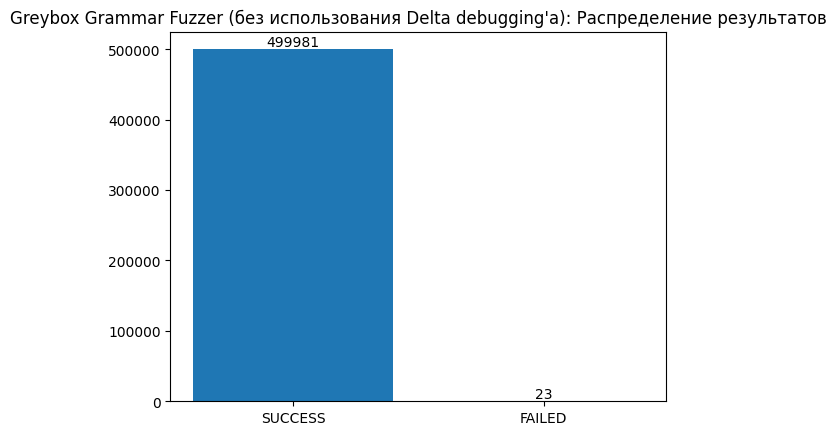

In [42]:
stats = greybox_grammar_fuzzer_without_delta_debugging.stats
x = list(map(lambda status: status.value, stats.keys()))
y = list(stats.values())

fig, ax = plt.subplots()
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)
plt.title("Greybox Grammar Fuzzer (без использования Delta debugging'а): Распределение результатов")

for index in range(len(x)):
    plt.text(index, y[index] + 5000, y[index], ha="center")

plt.bar(x, y)
plt.show()

In [43]:
title = "Найденные данные:"

print(title)
print(len(title)*"=", end="\n\n")

print(greybox_grammar_fuzzer_without_delta_debugging.failing_inputs)

Найденные данные:

{'[1]', '[1]\r'}


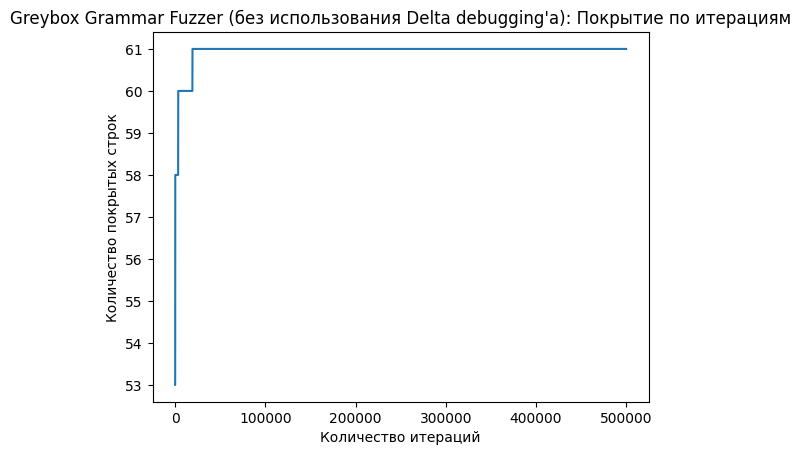

In [44]:
plt.title("Greybox Grammar Fuzzer (без использования Delta debugging'а): Покрытие по итерациям")
plt.plot(greybox_grammar_fuzzer_without_delta_debugging.coverage_history)
plt.xlabel("Количество итераций")
plt.ylabel("Количество покрытых строк")
plt.show()

In [45]:
title = "Итоговая популяция:"

print(title)
print(len(title)*"=", end="\n\n")

for seed in greybox_grammar_fuzzer_without_delta_debugging.population:
    print(seed.data)

Итоговая популяция:

{"abc1":{"abc2":[]},"abc2":false}
{"valueis":{"1":"","2":["","",""]}}
{"abc1":{"abc2":[""]},"abc2":false}
[2, 3]
[1]
[4]
{"values":{"1":10,"2":""}}
{"": ""}
{"abc1":{"abc2":[""]},"abc2":""}
{"abc1": {"abc2": [10]}, "abc2": false}
{"valueis":{"1":10,"2":[]}}
[""]
{"valueis":{"1":10,"2":["","",40]}}
[2,""]
""
{"values":{"1":10,"2":[3]}}
{"abc1":{"abc2":[""]},"": ""}
{"abc15":{"abc2":[10]},"": ""}
{"": "","123":12.3}
{"values": {"1": 10, "2": [20, 30, 40]}}
{"values":{"":"","2":""}}
{"": "","abc2":false}
"QL"
{"abc": 123, "123": 123}
{"":"q"}
{"": "","": ""}
{"vcalues":{"": "","I2":[]}}
["",""]
[]


__С__ использованием Delta debugging'а

In [46]:
greybox_grammar_fuzzer_with_delta_debugging = GreyboxGrammarFuzzer(
                                                    target=failed_parse,
                                                    seed=initial_seed,
                                                    mutator=mutator,
                                                    fragment_mutator=fragment_mutator,
                                                    min_mutations=3,
                                                    max_mutations=5,
                                                    tries=500_000,
                                                    delta_debugging=True,
                                                )

In [47]:
greybox_grammar_fuzzer_with_delta_debugging.fuzz()

  0%|          | 0/500000 [00:00<?, ?it/s]

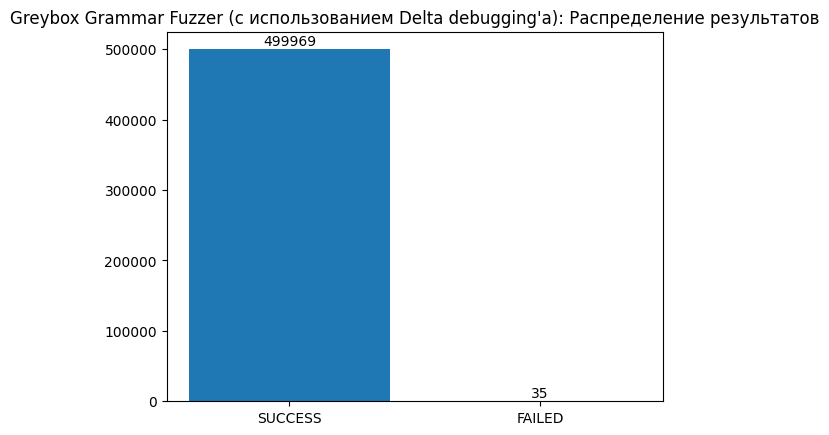

In [48]:
stats = greybox_grammar_fuzzer_with_delta_debugging.stats
x = list(map(lambda status: status.value, stats.keys()))
y = list(stats.values())

fig, ax = plt.subplots()
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)
plt.title("Greybox Grammar Fuzzer (c использованием Delta debugging'а): Распределение результатов")

for index in range(len(x)):
    plt.text(index, y[index] + 5000, y[index], ha="center")

plt.bar(x, y)
plt.show()

In [49]:
title = "Найденные данные:"

print(title)
print(len(title)*"=", end="\n\n")

print(greybox_grammar_fuzzer_with_delta_debugging.failing_inputs)

Найденные данные:

{'[1]', '[1]\r', '[1]\t', '[1\r]'}


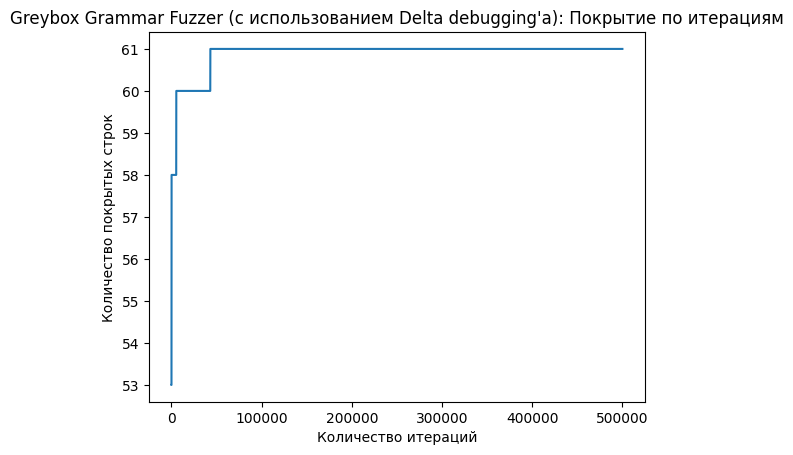

In [50]:
plt.title("Greybox Grammar Fuzzer (с использованием Delta debugging'а): Покрытие по итерациям")
plt.plot(greybox_grammar_fuzzer_with_delta_debugging.coverage_history)
plt.xlabel("Количество итераций")
plt.ylabel("Количество покрытых строк")
plt.show()

In [51]:
title = "Итоговая популяция:"

print(title)
print(len(title)*"=", end="\n\n")

for seed in greybox_grammar_fuzzer_with_delta_debugging.population:
    print(seed.data)

Итоговая популяция:

{"abc1": {"abc2": [10]}, "abc2": ""}
{"abc1": {"abc2": [""]}, "abc2": false}
{"abc1": {"abc2": []}, "abc2": false}
{"x": ""}
[1]
{"values": {"1": 10, "2": []}}
{"values": {"1": 10, "2": [20]}}
[9]
{"": ""}
{"abc1": {"abc2": [10]}, "abc2": false}
[""]
""
{")abc": "", "123": 1.23}
{"values": {"": "", "2": []}}
{"values": {"": "", "2": [""]}}
{"": "", "abc2": false}
{"abc": 123, "123": 123}
[2]
{"abc": 123, "": ""}
[]
